# Format Results

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# retain_results = "workspace/FiLLM/results/knowundo-copyright/qwen2-1.5b_retain_knowundo-copyright_checkpoint-347_noLORA_1e-04_10_0.01_retention_unlearn_seed42.csv"
retain_results = "workspace/FiLLM/results/tofu/qwen2-1.5b_retain_tofu_checkpoint-1237_noLORA_2.5e-05_10_0.01_retain99_forget01_perturbed_seed42.csv"
df_retain = pd.read_csv(retain_results)

# full_results = "workspace/FiLLM/results/knowundo-copyright/qwen2-1.5b_full_knowundo-copyright_checkpoint-496_noLORA_1e-04_10_0.01_full_unlearn_seed42.csv"
full_results = "workspace/FiLLM/results/tofu/qwen2-1.5b_full_tofu_checkpoint-1250_noLORA_2.5e-05_10_0.01_full_forget01_perturbed_seed42.csv"
df_full = pd.read_csv(full_results)

In [3]:
def get_results(exp_name):
    folder = exp_name
    files = os.listdir(folder)
    files = [f for f in files if re.match(r".*\.csv", f)]
    df = pd.DataFrame()
    for f in files:
        pth = os.path.join(folder, f)
        tmp = pd.read_csv(pth)
        # replace "Method" column with layer.#
        step_num = tmp['Method'].values[0].split("_")[1].split("-")[1]
        k = tmp['Method'].values[0].split("_")[6]
        tmp['Step'] = step_num
        tmp['k_val'] = k
        df = pd.concat([df, tmp])
    df['Step'] = df['Step'].astype(int)

    # add a df_full row for each layer
    k_vals = df['k_val'].unique()
    df_full_duplicated = pd.DataFrame([df_full.iloc[0]] * len(k_vals))
    df_full_duplicated['k_val'] = k_vals
    df_full_duplicated['Step'] = 0
    df = pd.concat([df, df_full_duplicated], ignore_index=True)

    df['k_val_offset'] = (df['k_val'].apply(lambda x: x.split("+")[1] if "+" in x else x)).astype(float)

    df = df.sort_values(by=['Step', 'k_val_offset']).reset_index(drop=True)

    return df

In [16]:
results = "workspace/FiLLM/results/tofu/PoT_forget01_k0.1_so-influence_5e-05_mlp,attn_False_sophia"
results_df = get_results(results)
if "tofu" in results:
    checkpoint_step = 2 # tofu
elif "knowundo" in results:
    checkpoint_step = 29 # knowundo

len(results_df)

110

In [5]:
def best_step(experiment, return_diff=False):
    # find the closest step to the ideal values
    df = experiment
    diff_retain = abs(df['ROUGE Retain'] - df_retain['ROUGE Retain'].values[0]) ** 2
    diff_forget = abs(df['ROUGE Forget'] - df_retain['ROUGE Forget'].values[0]) ** 2
    diff = np.sqrt(diff_retain + diff_forget)
    idx = diff.idxmin()
    if return_diff:
        return int(df.loc[idx]['Step']), diff[idx]
    else:
        return int(df.loc[idx]['Step'])

In [6]:
palette = sns.color_palette("coolwarm", 10)
palette

[(0.3383765114431373, 0.45281860883137254, 0.8793170768784313),
 (0.4570464785254902, 0.5940055499294118, 0.963029229690196),
 (0.5814861481882353, 0.7134505955294117, 0.9983143529411764),
 (0.7087196897176471, 0.8057213889294117, 0.9811168090470588),
 (0.8180564934117647, 0.8555896775450981, 0.9146376165490196),
 (0.9094595977529412, 0.8393864797647058, 0.8003313524235294),
 (0.9616447383764706, 0.7580291825411765, 0.6617823791647058),
 (0.963806056435294, 0.6341884145294118, 0.5137208491529413),
 (0.9182816725843137, 0.48417347218039214, 0.37779392507058823),
 (0.8301865219490197, 0.30473276355294115, 0.25489142806666665)]

In [7]:
for i, k_val in enumerate(results_df['k_val'].dropna().unique()):
    layer_df = results_df[results_df['k_val'] == k_val].reset_index(drop=True)
    step, diff = best_step(layer_df,return_diff=True)
    print(f"Best diff for k={k_val}: {diff:.4f} at step {step}")


Best diff for k=0.1+0: 0.0608 at step 4
Best diff for k=0.1+0.1: 0.0475 at step 4
Best diff for k=0.1+0.2: 0.0564 at step 4
Best diff for k=0.1+0.3: 0.0770 at step 4
Best diff for k=0.1+0.4: 0.0929 at step 4
Best diff for k=0.1+0.5: 0.1413 at step 4
Best diff for k=0.1+0.6: 0.2067 at step 4
Best diff for k=0.1+0.7: 0.2339 at step 4
Best diff for k=0.1+0.8: 0.3372 at step 2
Best diff for k=0.1+0.9: 0.3449 at step 4


In [11]:
for i, k_val in enumerate(results_df['k_val'].dropna().unique()):
    layer_df = results_df[results_df['k_val'] == k_val].reset_index(drop=True)
    step, diff = best_step(layer_df,return_diff=True)
    print(f"Best diff for k={k_val}: {diff:.4f} at step {step}")


Best diff for k=0.1+0: 0.0308 at step 18
Best diff for k=0.1+0.1: 0.0389 at step 10
Best diff for k=0.1+0.2: 0.0518 at step 6
Best diff for k=0.1+0.3: 0.0586 at step 6
Best diff for k=0.1+0.4: 0.0669 at step 6
Best diff for k=0.1+0.5: 0.0678 at step 6
Best diff for k=0.1+0.6: 0.0738 at step 6
Best diff for k=0.1+0.7: 0.1239 at step 6
Best diff for k=0.1+0.8: 0.1010 at step 4
Best diff for k=0.1+0.9: 0.0999 at step 4


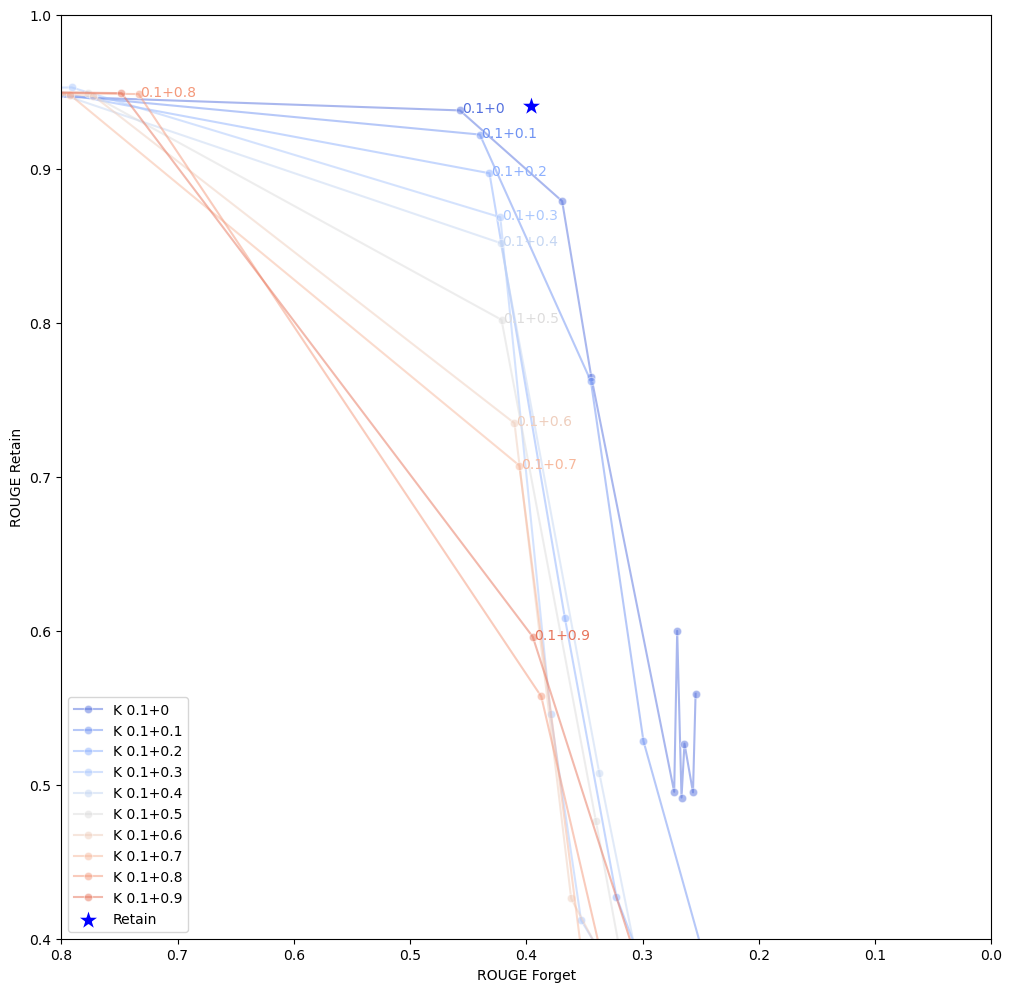

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))

alpha = 0.5
palette = sns.color_palette("coolwarm", 11) # hls, husl, coolwarm

for i, k_val in enumerate(results_df['k_val'].dropna().unique()):
    layer_df = results_df[results_df['k_val'] == k_val].reset_index(drop=True)
    color = palette[i]
    sns.lineplot(x="ROUGE Forget", y="ROUGE Retain", data=layer_df, ax=ax, marker="o", c=color, alpha=alpha, label=f"K {k_val}")
    step = best_step(layer_df)
    text_x = layer_df["ROUGE Forget"][step//checkpoint_step] - 0.0015
    text_y = layer_df["ROUGE Retain"][step//checkpoint_step] - 0.0015
    ax.annotate(f"{k_val}", (text_x, text_y), fontsize=10, color=color, alpha=1, clip_on=True, zorder=2)


sns.scatterplot(x="ROUGE Forget", y="ROUGE Retain", data=df_retain, ax=ax, marker="*", s=300, c="b", alpha=1, zorder=2, label="Retain")
# sns.scatterplot(x="ROUGE Forget", y="ROUGE Retain", data=df_full, ax=ax, marker="o", c="blue", alpha=1, zorder=2)


plt.xlim(.8, 0)
plt.ylim(0.4, 1)
plt.legend(loc='lower left')

# plt.xlim(0.55, 0.35)
# plt.ylim(0.7, 1)
# plt.legend(loc='lower right')

# plt.xlim(1, 0)
# plt.ylim(0, 1)

plt.show()

# save
# fig.savefig("workspace/FiLLM/figures/PF_so-influence_koffset_5e-05.svg", format="svg")

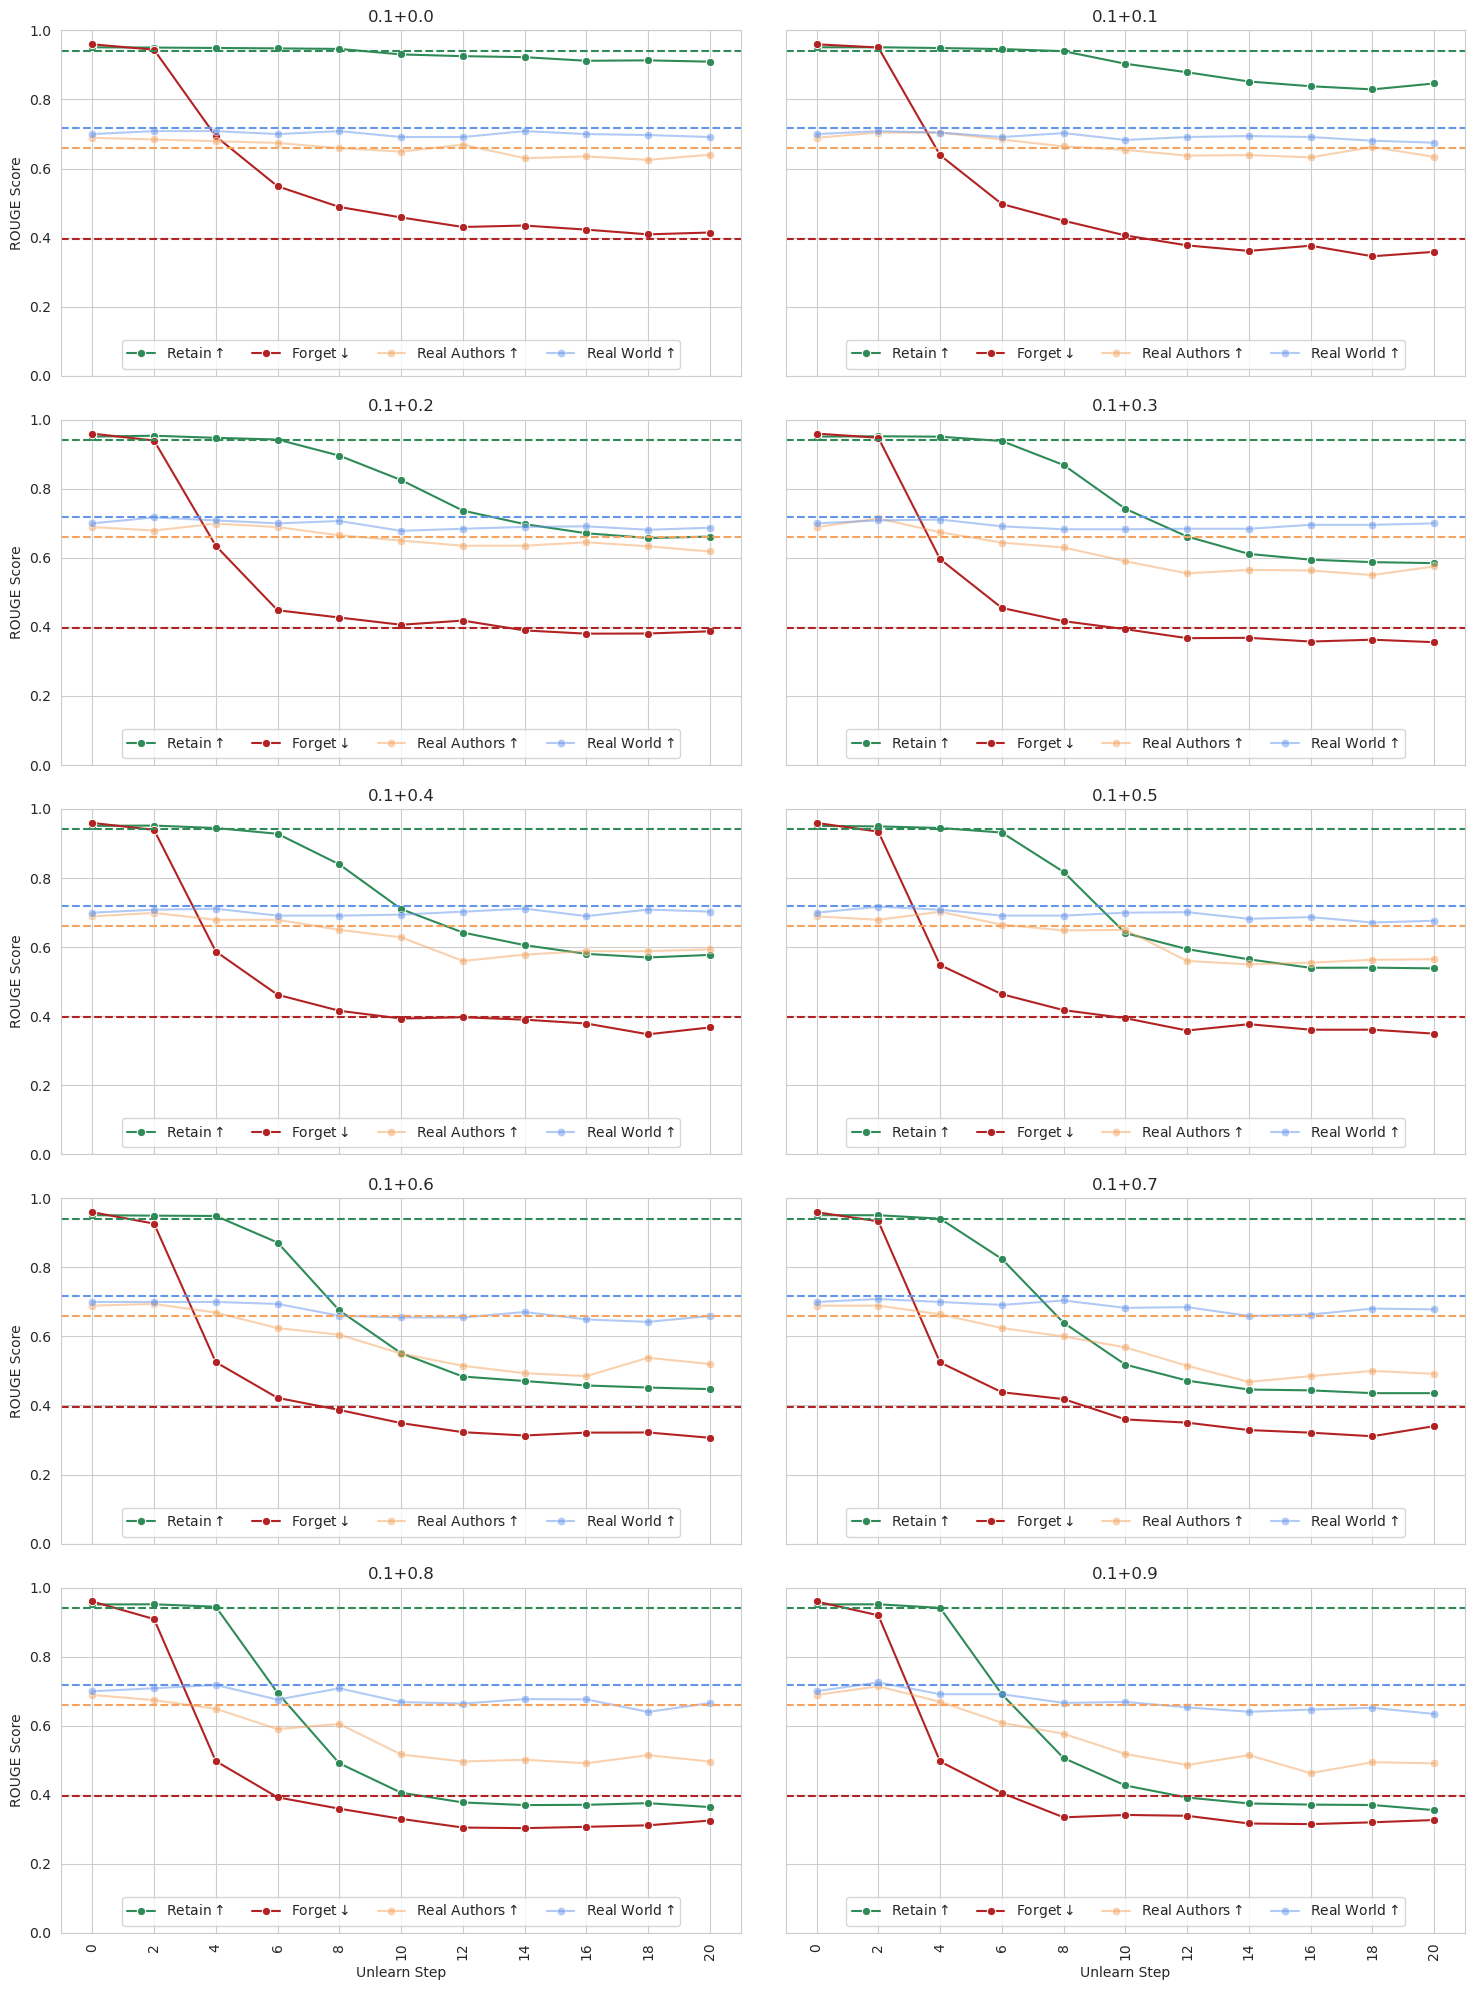

In [106]:
# create a plot for the trajectory of each layer over steps in a large plot with 28 subplots
sns.set_style(style="whitegrid")

fig, axs = plt.subplots(5, 2, figsize=(15, 20), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    k_val = results_df['k_val_offset'].unique()[i]
    df_ = results_df[results_df['k_val_offset'] == k_val].reset_index(drop=True)
    sns.lineplot(x="Step", y="ROUGE Retain", data=df_, ax=ax, marker="o", label="Retain$\\uparrow$", c="seagreen", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Forget", data=df_, ax=ax, marker="o", label="Forget$\\downarrow$", c="firebrick", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Real Authors", data=df_, ax=ax, marker="o", label="Real Authors$\\uparrow$", c="sandybrown", alpha=0.5)
    sns.lineplot(x="Step", y="ROUGE Real World", data=df_, ax=ax, marker="o", label="Real World$\\uparrow$", c="cornflowerblue", alpha=0.5)

    # plot horizontal line for retain rouge and forget rouge
    ax.axhline(y=df_retain['ROUGE Retain'].values[0], color='seagreen', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Forget'].values[0], color='firebrick', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Real Authors'].values[0], color='sandybrown', linestyle='--')
    ax.axhline(y=df_retain['ROUGE Real World'].values[0], color='cornflowerblue', linestyle='--')

    #change x axis name
    ax.set_xlabel("Unlearn Step")
    ax.set_ylabel("ROUGE Score")

    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=90)

    if "tofu" in results:
        ax.set_xticks(np.arange(0, 21, 2))
    elif "knowundo" in results:
        ax.set_xticks(np.arange(0, 291, 29))

    ax.set_title(f"0.1+{k_val}")

    # move legend to bottom center
    ax.legend(loc='lower center', ncol=4)

plt.tight_layout()
plt.show()

# fig.savefig("workspace/FiLLM/figures/PT_3e05_sharedaxis_tofu.svg", format="svg")